# Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Reading data.

In [2]:
fname = 'train.csv'
df = pd.read_csv(fname, index_col='Id')
n_examples, n_features = df.shape
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Remove some features

In [3]:
lst = ['MoSold', 'YrSold', 'BldgType',     # not a useful information
       'MasVnrType', 'MasVnrArea',         # not a useful information, nobody cares about masonry
       'Heating', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'LotConfig',
       'GarageArea',                       # redundant, highly correlated with GarageCars (r ~ 0.88)
       'GarageYrBlt',                      # redundant (almost always == YearBuilt)
       'GarageType', 'HouseStyle', 
       'MiscFeature', 'MiscVal']           # may be useful, but the processing will be hard and long

df.drop(columns=lst, inplace=True)

### Numerical-valued vs nominal features


In [4]:
numerical = df.select_dtypes(include=[np.number]).columns
nominal = df.select_dtypes(exclude=[np.number]).columns

## Missing data handling

Numerical:
- LotFrontage      259
- GarageYrBlt       81
- MasVnrArea         8

Nominal:
- PoolQC           1445
- MiscFeature      1398
- Alley            1362
- Fence            1171
- FireplaceQu       686
- GarageType         81
- GarageFinish       81
- GarageQual         81
- GarageCond         81
- BsmtExposure       38
- BsmtFinType2       38
- BsmtCond           37
- BsmtFinType1       37
- BsmtQual           37
- Electrical          1

### Missing Values: nominal features

Missing value means absense of some utility or house feature. For example, missing **FireplaceQu** means that there is no fireplase. 

I fill NA with 'No':

In [5]:
lst = ['PoolQC', 'Fence', 'Alley', 'FireplaceQu', 'GarageFinish', 
       'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 
       'Electrical']

df.loc[:, lst] = df[lst].fillna('No')

### Missing Values: Lot Frontage

We fill group data by **GarageCars**, and then fill missing values with means in the corresponding group:

In [6]:
def get_mask_isNA(column_name):
    return pd.isna(df[column_name])


mask_isNA = get_mask_isNA('LotFrontage')
missed = df[mask_isNA]
mean_frontages = (df[['LotFrontage', 'GarageCars']]
                  .groupby('GarageCars')
                  .mean()
                  .squeeze() 
                 )


def fillna_frontage(r): 
    r.loc['LotFrontage'] = mean_frontages.loc[r['GarageCars']]
    return r


df.loc[mask_isNA] = missed.apply(fillna_frontage, axis=1)

## Non-numeric features encoding

### Nominal features

**Features:** SaleCondition, MSZoning

**Encoding strategy:** OneHot

In [7]:
df = df.merge(pd.get_dummies(df[['SaleCondition', 'MSZoning']]),
              left_index=True, 
              right_index=True, 
              how='left')
df.drop(columns=['SaleCondition', 'MSZoning'], inplace=True)

**Features:** Condition1, Condition2

**Encoding strategy:** split into 3 binary variables.

1. NearArtery_or_Feedr: Artery or Feedr is available

2. PositiveFeat: PosA or PosN is available

3. NearRailroad: RRAe or RRAn or RRNe or RRNn is available

In [8]:

def get_dummies_if_any(df, lst):
    return  ((np.isin(df['Condition1'], lst) |
              np.isin(df['Condition2'], lst))
                     .astype(int)
            )

df['NearArtery_or_Feedr'] = get_dummies_if_any(df, ['Artery', 'Feedr'])
df['PositiveFeat'] = get_dummies_if_any(df, ['PosA', 'PosN'])
df['NearRailroad'] = get_dummies_if_any(df, ['RRAe', 'RRAn', 'RRNe', 'RRNn'])
df.drop(columns=['Condition1','Condition2'], inplace=True)

**Features**: LotShape 

**Encoding strategy**: 1 if regular, 0 else

In [9]:
df['RegularityOfShape'] = ((df['LotShape'] == 'Reg') | (df['LotShape'] == 'IR1')).astype(int)

**Features:** Foundation

**Encoding strategy**: 1 if not Wood, 0 else

In [10]:
df['Foundation'] = (df['Foundation'] != 'Wood').astype(int)

### Ordinal features
**Encoding strategy**: Usual procedure of ordinal encoding. I found my code more convenient than one with ``OrdinalEncoder`` from scikit-learn.

Some strings are commented, because some features were excluded (my own decision). You may uncomment some lines, if you want to include them back.

In [11]:
lst = ['PoolQC', 'KitchenQual', 
       'HeatingQC', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'FireplaceQu',
       'GarageQual', 'GarageCond']
quality_map={'No': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df.loc[:, lst] = df[lst].apply(lambda c: c.map(quality_map), axis=0).fillna(0)

In [12]:
#================================================
def get_quality_coef(column_name, grades_to_numbers):
    return df[column_name].map(grades_to_numbers)

# mask_missed = df['Fence'] == 'No'
# df.loc[~mask_missed, 'Fence'] = 1
# df.loc[mask_missed, 'Fence'] = 0
df['Fence'] = get_quality_coef('Fence', 
                               {'No': 0}).fillna(1)
# df['BsmtExposure'] = get_quality_coef('BsmtExposure', 
#                                       {'No': 1, 'Mn': 2, 'Av': 3, 'Ex' : 4}).fillna(0)
df['BsmtQuartersQ'] = get_quality_coef('BsmtFinType1', 
                                       {'BLQ':1, 'ALQ':2, 'GLQ':3}).fillna(0) +\
                      get_quality_coef('BsmtFinType2', 
                                       {'BLQ':1, 'ALQ':2, 'GLQ':3}).fillna(0)
df['CentralAir'] = df['CentralAir'].map({'N':0, 'Y':1})
df['Electrical'] = get_quality_coef('Electrical', {'FuseP':1}).fillna(0)
# df['GarageFinish'] = get_quality_coef('GarageFinish', 
#                                       {'Fin':3, 'RFn':2, 'Unf':1}).fillna(0)
df['PavedDrive'] = get_quality_coef('PavedDrive', 
                                    {'N':1, 'P':2, 'Y':3})
df['Utilities'] = get_quality_coef('Utilities', 
                                   {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}).fillna(0)
# df['LandContour'] = get_quality_coef('LandContour', 
#                                      {'Low':3, 'Bnk':2, 'Hls':1}).fillna(0)
# df['LandSlope'] =  get_quality_coef('LandSlope', 
#                                     {'Gtl':1, 'Mod':2, 'Sev':3})
df['DeductionsFunctional'] = get_quality_coef('Functional', 
                                              {'Typ':0, 'Min1':1, 'Min2':2,
                                               'Mod':3, 'Maj1':4, 'Maj2':5}).fillna(0)
df['DamageOfFunctionality'] = get_quality_coef('Functional', 
                                               {'Sev':1, 'Sal': 2}).fillna(0)
df['Street'] = get_quality_coef('Street', {'Grvl':1, 'Pave':2})
df['Alley'] = get_quality_coef('Alley', {'Grvl':1, 'Pave':2}).fillna(0)


# Explore correlations between features

Goals:

1. Find all features that are highly correlated with target (SalePrice)

2. Find correlations between features to prevent multicolinearity

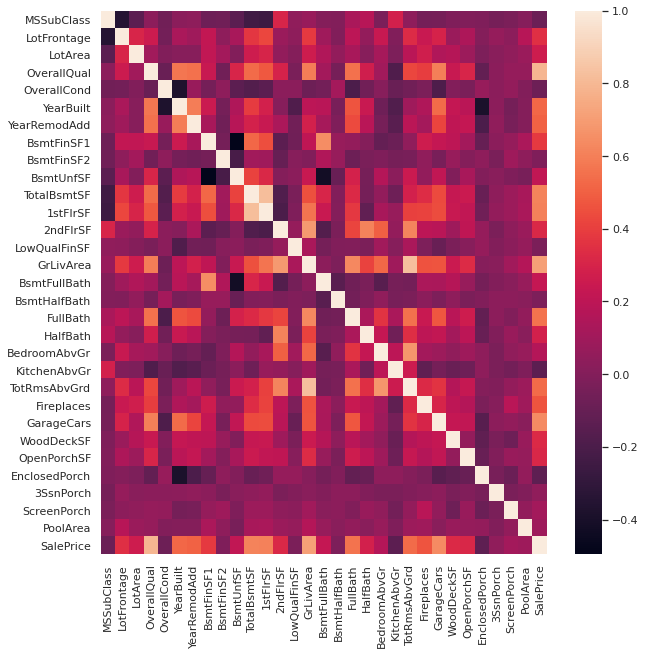

In [13]:
numeric_corr = df[numerical].corr()
sns.set(rc={'figure.figsize':(10, 10)})
ax = sns.heatmap(numeric_corr);


**Correlation with target:** OverallQual, GrLivArea, TotalBsmtSF, 1ndFlrSf, GarageCars, YearBuilt, YearRemodAdd, TotalRoomsAbvGr, Fireplaces, FullBath

**Groups of correlated features:**
- TotalBsmtSF: 1FlrSF, OverallQual, BsmtFinSF1
- GrLivArea: TotalRmsAbvGr, BedroomsAbvGr, OverallQual, 1ndFlrSf, 2ndFlrSf, FullBath
- BsmtFinSF1: BsmtFullBath
- OverallQual: YearBuilt, YearRemodAdd, GarageCars
- YearBuilt: YearRemodAdd


## Feature generation

### Aggregations

1. Mean sale price by region

In [14]:
# mean price among neighbours
means_neigh = (df.groupby('Neighborhood')
                 .agg({'SalePrice':'mean'})
                 .rename(columns={'SalePrice':'MeanSalePriceOfNeighbours'})
               )
means_neigh.to_csv('mean_price_of_neighbours.csv')

df = df.merge(means_neigh, how='left', left_on='Neighborhood', right_index=True)

### Combinations
1. Some simple combinations

In [15]:
df['TotBath'] = df['BsmtFullBath'] + df['FullBath'] +\
                0.5*(df['BsmtHalfBath'] + df['HalfBath'])

# rating: combine quaility and number
df['KitchensRating'] = df['KitchenAbvGr']*df['KitchenQual']
df['FireplacesRating'] = df['Fireplaces']*df['FireplaceQu']
df['GarageRating'] = df['GarageCars']*df['GarageQual']

## Feature selection

**Currently used strategy:** 

- Selection is based on analysis of correlations

- Removing most of the features to prevent overfitting. 

In [16]:
df.drop(columns=['BsmtExposure', 'BsmtFullBath', 'FullBath', 'BsmtHalfBath', 
                 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                 '1stFlrSF', '2ndFlrSF', 
                 'LandContour', 'LandSlope', 'KitchenQual', 
                 'HeatingQC', 'ExterQual', 'ExterCond',
                 'BsmtQual', 'BsmtCond', 'FireplaceQu',
                 'GarageQual', 'GarageCond', 'PoolQC', 
                 'WoodDeckSF', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'MSSubClass', 'DamageOfFunctionality',
                 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 
                 'SaleCondition_AdjLand', 'SaleCondition_Family', 
                 'SaleCondition_Alloca', 'Foundation', 'LowQualFinSF',
                 'NearRailroad', 'MSZoning_FV', 'Fireplaces', 
                 'GarageCars', 'OverallCond', 'GarageFinish',
                 'SaleType'], inplace=True)
# we will drop TotRmsAbvGrd, because 
# it's redundant(highly correlated with GrLivArea) r = 0.82
df.drop(columns=['TotRmsAbvGrd'], inplace=True)
# if remodelling of house improves quality, OverallQual must
# contain this information
df.drop(columns=['YearRemodAdd'], inplace=True)
df.drop(columns=['LotShape'], inplace=True)
df.drop(columns=['BsmtFinType1', 'BsmtFinType2'], inplace=True)
df.drop(columns=['Functional'], inplace=True)
df.drop(columns=['Neighborhood'], inplace=True)

**Alternative strategy:** 

- At this stage, do not remove any features
- Use LASSO or XGBoost for feature selection

# Summary

In [17]:
print("We end up with:\n{} features \n{} examples".format(df.shape[1]-1, df.shape[0]))
print(f"Total # of missing values: {df.isna().sum().sum()}")
print(f"Total # of non-numerical features: {df.select_dtypes(exclude=[np.number]).shape[1]}")



We end up with:
32 features 
1460 examples
Total # of missing values: 0
Total # of non-numerical features: 0


Correlations with target: 


SalePrice                    1.000000
OverallQual                  0.790982
MeanSalePriceOfNeighbours    0.738630
GrLivArea                    0.708624
GarageRating                 0.650761
Name: SalePrice, dtype: float64

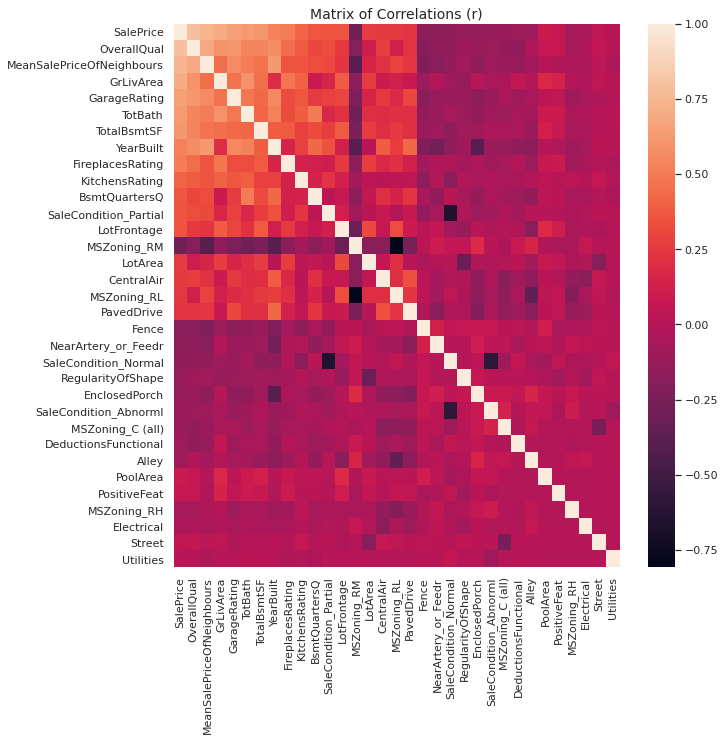

In [18]:
print('Correlations with target: ')
corr = df.corr()['SalePrice'].sort_values(ascending=False, key=lambda x: np.abs(x))
display(corr.head())
print('\n')
# Intrinsic correlations:
lst = corr.index
sns.heatmap(df[lst].corr())
plt.title("Matrix of Correlations (r)", fontsize=14);

## Save preprocessed data

In [19]:
df.to_csv('preprocessed1_' + fname)